# FloodNet Project

## Imports

In [1]:
#import sys
#!pip install mlxtend

In [2]:
from PIL import Image
import pandas as pd
import numpy as np
import os
import glob
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import cv2

from torch import nn
import torch.nn.functional as F
#import model.resnet as models

from torch.optim import SGD

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.plotting import plot_confusion_matrix

import time


## First Tries

## Dataset

In [3]:
#helper function
#code in this cell from https://albumentations.ai/docs/examples/example_kaggle_salt/
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))

        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

In [4]:
class FloodData(Dataset):

    # mapping between label class names and indices
    LABEL_CLASSES = {
      'background': 		  0,
      'building-flooded': 			    1,
      'building-non-flooded': 	  2,
      'road-flooded': 				      3,
      'road-non-flooded': 			    4,
      'water': 			    5,
      'tree':   6,
      'vehicle': 				    7,
      'pool': 				    8,
      'grass': 			  9
    }
   

    def __init__(self, transforms=None, split='train'):
        
        self.transforms = transforms
        
        SPLIT = pd.read_csv("FloodNet_split_train_valid_test.csv", sep=',', header=None, names=["Column1", "Column2", "Column3"])
        SPLIT["Column1"] = SPLIT["Column1"].map(lambda x: "data/image/" + x)
        SPLIT["Column2"] = SPLIT["Column2"].map(lambda x: "data/mask/" + x)
        
        splitted_set = SPLIT[SPLIT["Column3"]==split]
        
        # prepare data
        self.data = list(zip(splitted_set["Column1"], splitted_set["Column2"]))                                  # list of tuples of (image path, label class)
        """
        images = np.empty((len(self.data)*3000,len(self.data)*4000,3))
        
        for i in range(len(self.data)):
            images[i] = np.array()
            Image.open()
        """ 
            
    #TODO: please provide the remaining functions required for the torch.utils.data.Dataset class.
    def __len__(self):
        return len(self.data)


    def __getitem__(self, x):
        imgName, labelsName = self.data[x]

        img = np.array(Image.open(imgName))
        labels = np.array(Image.open(labelsName))
        if self.transforms is not None:
            transformed = self.transforms(image=img, mask=labels)
            #code to visualize transformation - uncomment if want to use
            #visualize(transformed["image"], transformed["mask"], img, labels)
            img = transformed['image']
            labels = transformed['mask']
        else:
            img, labels = img[:3000, :4000,:], labels[:3000, :4000]
        
        img, labels = torch.tensor(img).float(), torch.tensor(labels).long()
        #move band dimension to the first dimension, because it is expected like this in the model
        img = torch.movedim(img, 2, 0)

        return img, labels


In [5]:
mean, std = [106.5385, 116.1601,  87.6059], [53.1837, 49.5205, 53.5828]

In [6]:
transform_train = A.Compose([
    A.RandomSizedCrop(min_max_height = [1000, 2500], height=713, width=713),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ShiftScaleRotate(p=0.5),
    #A.Blur(blur_limit = 3),
    A.RandomRotate90(),
    #A.OpticalDistortion(),
    #A.GridDistortion(),
    #A.Resize(height=713, width=713),
    
    #Normalization is applied by the formula: img = (img - mean * max_pixel_value) / (std * max_pixel_value)
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

transform_val = A.Compose([
    A.RandomSizedCrop(min_max_height = [500, 2500], height=713, width=713),
    #A.Resize(height=713, width=713),
    A.Normalize(mean = mean, std = std, max_pixel_value=1)
])

In [7]:
train_dataset = FloodData(transforms = transform_train, split = 'train')
val_dataset = FloodData(transforms = transform_val, split = 'valid')
test_dataset = FloodData(transforms = transform_val, split = 'test')

In [8]:
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle=True)
next(iter(train_loader))[0]

tensor([[[[ 1.5317,  0.0087,  1.0992,  ...,  1.8701,  1.8137,  1.9642],
          [ 0.6104,  0.8736,  1.2685,  ...,  1.5505,  1.5129,  1.5505],
          [-0.0477,  0.1967,  1.1180,  ...,  1.5317,  1.5505,  1.1180],
          ...,
          [ 2.4342,  2.5282,  2.4906,  ...,  0.8360,  1.3625,  1.5129],
          [ 2.5282,  2.5659,  2.5470,  ...,  1.0804,  1.1368,  1.2309],
          [ 2.3590,  2.5847,  2.5094,  ...,  1.1933,  0.7420,  0.9112]],

         [[ 2.0565,  0.5218,  1.6930,  ...,  1.7132,  1.6728,  1.8344],
          [ 1.0670,  1.4103,  1.8748,  ...,  1.3901,  1.3497,  1.3901],
          [ 0.4612,  0.8247,  1.7738,  ...,  1.4507,  1.4911,  0.9863],
          ...,
          [ 2.3998,  2.5210,  2.4806,  ...,  1.2690,  1.7536,  1.8748],
          [ 2.5210,  2.5614,  2.5412,  ...,  1.5315,  1.5113,  1.5921],
          [ 2.3392,  2.5614,  2.4806,  ...,  1.6123,  1.1276,  1.2690]],

         [[ 0.9592, -0.6832,  0.3806,  ...,  1.7616,  1.7057,  1.8363],
          [-0.1793,  0.1380,  

## Resnet model

In [9]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [10]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, deep_base=True):
        super(ResNet, self).__init__()
        self.deep_base = deep_base
        if not self.deep_base:
            self.inplanes = 64
            self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
        else:
            self.inplanes = 128
            self.conv1 = conv3x3(3, 64, stride=2)
            self.bn1 = nn.BatchNorm2d(64)
            
        #on a décalé
        self.conv2 = conv3x3(64, 64)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = conv3x3(64, 64) #128)
        self.bn3 = nn.BatchNorm2d(64) #128)
            
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    # for the PSPNet, this forward is never used. We will still leave it for completion
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        if self.deep_base:
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## PPM model

In [11]:
class PPM(nn.Module):
    def __init__(self, in_dim, reduction_dim, bins):
        super(PPM, self).__init__()
        self.features = []
        for bin in bins:
            self.features.append(nn.Sequential(
                nn.AdaptiveAvgPool2d(bin),
                nn.Conv2d(in_dim, reduction_dim, kernel_size=1, bias=False),
                nn.BatchNorm2d(reduction_dim),
                nn.ReLU(inplace=True)
            ))
        self.features = nn.ModuleList(self.features)

    def forward(self, x):
        x_size = x.size()
        #print("PPM size of x:", x_size)
        out = [x]
        for f in self.features:
            out.append(F.interpolate(f(x), x_size[2:], mode='bilinear', align_corners=True))
        return torch.cat(out, 1)

## PSPNet model

In [12]:
class PSPNet(nn.Module):
    def __init__(self, layers=50, bins=(1, 2, 3, 6), dropout=0.1, classes=10, zoom_factor=8, criterion=nn.CrossEntropyLoss(ignore_index=255), pretrained=True):
        super(PSPNet, self).__init__()
        assert layers in [50, 101, 152]
        assert 2048 % len(bins) == 0
        assert classes > 1
        assert zoom_factor in [1, 2, 4, 8]
        self.zoom_factor = zoom_factor
        self.criterion = criterion    
        
        # resnet101: 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth'
        #add condition if we want to remove it (see argument pretrained)
        path_to_pretrained = "./resnet101.pth"
        resnet = ResNet(Bottleneck, [3, 4, 23, 3], num_classes=1000, deep_base=False)
        resnet.load_state_dict(torch.load(path_to_pretrained), strict=False)

        
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.conv2, resnet.bn2, resnet.relu, resnet.conv3, resnet.bn3, resnet.relu, resnet.maxpool)
        self.layer1, self.layer2, self.layer3, self.layer4 = resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4

        
        # change parameters for layers 3 and 4
        for n, m in self.layer3.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (2, 2), (2, 2), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
        for n, m in self.layer4.named_modules():
            if 'conv2' in n:
                m.dilation, m.padding, m.stride = (4, 4), (4, 4), (1, 1)
            elif 'downsample.0' in n:
                m.stride = (1, 1)
                
                
        # feature dimension after Resnet
        fea_dim = 2048
        self.ppm = PPM(fea_dim, int(fea_dim/len(bins)), bins)
        fea_dim *= 2
        self.cls = nn.Sequential(
            nn.Conv2d(fea_dim, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=dropout),
            nn.Conv2d(512, classes, kernel_size=1)
        )
        if self.training:
            self.aux = nn.Sequential(
                nn.Conv2d(1024, 256, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=dropout),
                nn.Conv2d(256, classes, kernel_size=1)
            )

            
            
    def forward(self, x, y=None):
        x_size = x.size()
        assert (x_size[2]-1) % 8 == 0 and (x_size[3]-1) % 8 == 0
        h = int((x_size[2] - 1) / 8 * self.zoom_factor + 1)
        w = int((x_size[3] - 1) / 8 * self.zoom_factor + 1)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x_tmp = self.layer3(x)
        x = self.layer4(x_tmp)
        # use Pyramid Pooling Model
        x = self.ppm(x)
        x = self.cls(x)
        if self.zoom_factor != 1:
            x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=True)

        if self.training:
            aux = self.aux(x_tmp)
            if self.zoom_factor != 1:
                aux = F.interpolate(aux, size=(h, w), mode='bilinear', align_corners=True)
            main_loss = self.criterion(x, y)
            aux_loss = self.criterion(aux, y)
            return x.max(1)[1], main_loss, aux_loss
        else:
            return x

## Training step

In [13]:
def training_step(batch, model, optimizer, aux_weight, device="cuda"):
    # TODO fill this function with the training step code
    start = time.perf_counter()
    
    model.train()
    optimizer.zero_grad()
    model.zero_grad()
    
    # TODO retrieve image and label from the batch
    x, y = batch

    # TODO move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    # TODO forward pass
    y_hat, main_loss, aux_loss = model(x, y)
    
    # TODO loss calculation
    loss = main_loss + aux_weight * aux_loss
  
    # TODO implement backprop and model update
    loss.backward() # backpropoagation of gradients
    optimizer.step() # update model parameters

    # lets also calculate accuracy for fun
    # FYI
    # .cpu() moves the data back to cpu (if on GPU)
    # .detach() removes gradients (we dont need them for accuracy)
    # .numpy() converts the tensor to numpy for better handling later
    #predictions = y_hat.argmax(1).cpu().detach().numpy() #argmax is done in the model pspnet
    prediction = y_hat.cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()

    # accuracy is the mean of correct (1) and incorrect (0) classifications
    accuracy = (prediction == ground_truth).mean()
    
    end = time.perf_counter()
    #print("time for each training step on a batch : ", end-start)

    #print(prediction, ground_truth)
    return loss, accuracy, prediction, ground_truth

In [14]:
if torch.cuda.is_available():
    device = "cuda"
print(device)

cuda


In [15]:
def train_epoch(train_dl, model, optimizer, aux_weight, device):
    
    # collect some statistics
    losses, accuracies, predictions, ground_truths  = [], [], [], []
    i=0
    for batch in train_dl:
        #print("new batch")
        # TODO call training_step
        loss, accuracy, prediction, ground_truth = training_step(batch, model, optimizer, aux_weight, device = device)
        
        # append statistics
        losses.append(loss.cpu().detach().numpy())
        accuracies.append(accuracy)
        predictions.append(prediction)
        ground_truths.append(ground_truth)
        
        if i>19:
            break
        i+=1

    # return averaged losses and accuracies
    return np.stack(losses).mean(), np.stack(accuracies).mean(), np.hstack(predictions), np.hstack(ground_truths)

In [16]:
learning_rate = 0.01
model = PSPNet()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
num_epochs = 1
aux_weight = 0.4

stats = []
for epoch in range(num_epochs):
    # TODO: call train_epoch
    
    start = time.perf_counter()
    
    train_loss, train_accuracy, train_pred, train_ground_truth = train_epoch(train_loader, model, optimizer, aux_weight, device)
    
    end = time.perf_counter()
    
    print(f"epoch {epoch+1}; trainloss {train_loss:.2f}, train accuracy {train_accuracy*100:.2f}%")
    print("time for one epoch :", end - start)
    
    stats.append({
        "trainloss":float(train_loss),
        "trainaccuracy":float(train_accuracy),
        "epoch":epoch
    })

epoch 1; trainloss 2.36, train accuracy 49.70%
time for one epoch : 40.267992747947574


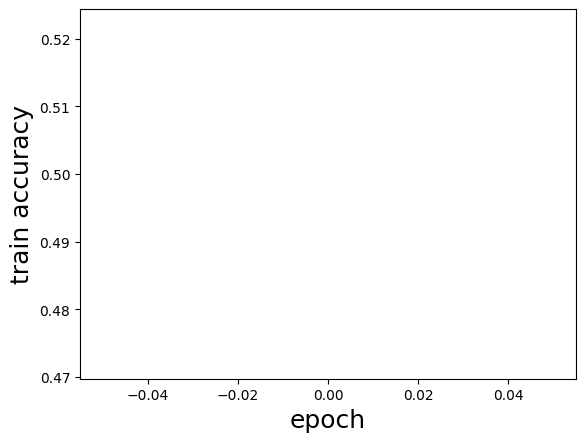

In [18]:
train_losses = np.stack([stat["trainloss"] for stat in stats])
train_accuracy = np.stack([stat["trainaccuracy"] for stat in stats])
epoch = np.stack([stat["epoch"] for stat in stats])

fig, ax = plt.subplots()
ax.plot(epoch, train_accuracy)
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("train accuracy", fontsize=18)
fig.savefig('train_accuracy'+'.pdf', format='pdf', bbox_inches = 'tight')

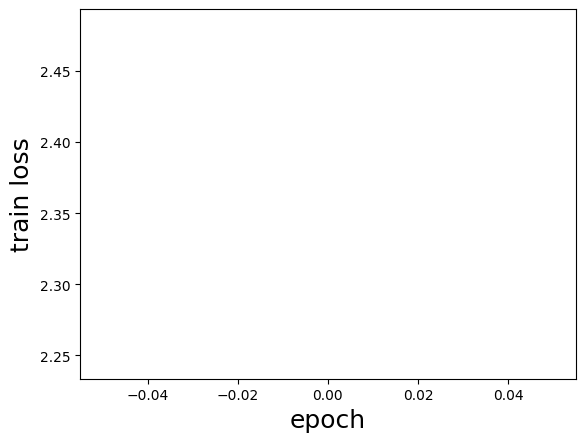

In [19]:
fig, ax = plt.subplots()
ax.plot(epoch, train_losses)
ax.set_xlabel("epoch", fontsize=18)
ax.set_ylabel("train loss", fontsize=18)
fig.savefig('train_loss'+'.pdf', format='pdf', bbox_inches = 'tight')

In [20]:
def print_confusion_matrix(prediction, ground_truth, save_name='train_confusion_matrix'):
    labels_in_data = []
    for key in FloodData.LABEL_CLASSES.keys():
        if FloodData.LABEL_CLASSES[key] in ground_truth:
            labels_in_data.append(key)

    cm = confusion_matrix(y_true=ground_truth, y_pred=prediction)
    fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap="Blues", class_names=labels_in_data)
    plt.xlabel('Predicted label', fontsize=18)
    plt.ylabel('True label', fontsize=18)
    fig.savefig(save_name+'.pdf', format='pdf', bbox_inches = 'tight')

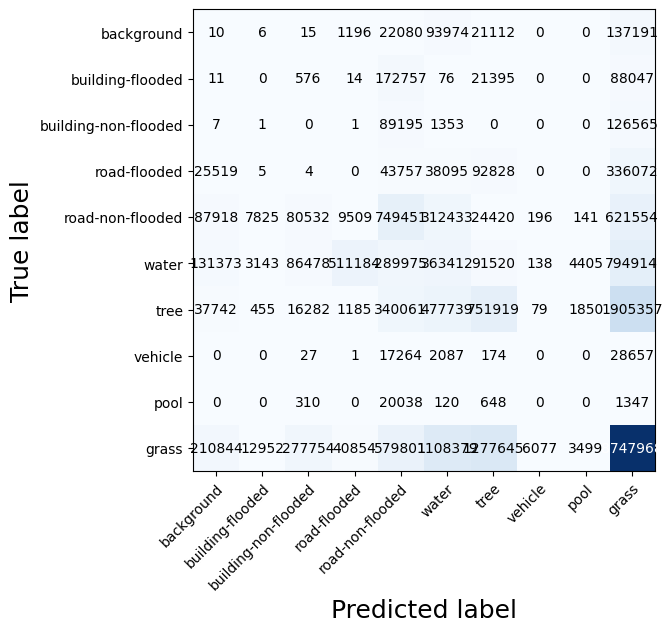

In [21]:
train_pred_new = np.concatenate(np.concatenate(train_pred))
train_ground_truth_new = np.concatenate(np.concatenate(train_ground_truth))

print_confusion_matrix(train_pred_new, train_ground_truth_new)

# Validation

In [22]:
# TODO wrap it into a DataLoader (batch_size=16, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size=2, shuffle=False)

import torch.nn.functional as F

@torch.no_grad() # we skip the calculation of the gradient graph here to save time
def prediction_step(batch, model, criterion=nn.CrossEntropyLoss(ignore_index=255), device="cuda"):
    model.eval()
    
    # TODO retrieve image and label from the batch
    x, y = batch
    
    # TODO move model and code to GPU
    model = model.to(device)
    x = x.to(device)
    y = y.to(device)
    
    # TODO forward pass
    y_hat = model(x)
    
    # TODO loss calculation (only for statistics)
    loss = criterion(y_hat, y)
    
    # lets also calculate accuracy for statistics (you can copy from training_step)
    predictions = y_hat.argmax(1).cpu().detach().numpy()
    ground_truth = y.cpu().detach().numpy()
    
    accuracy = (predictions == ground_truth).mean()
    
    return loss, accuracy, predictions, ground_truth

In [26]:
# store stats
losses, accuracies, predictions, ground_truths = [], [], [], []

i=1
for batch in val_dl:
    # TODO run prediction_step
    loss, accuracy, prediction, ground_truth = prediction_step(batch, model)
    
    # append to stats
    losses.append(loss.cpu().detach().numpy())
    accuracies.append(accuracy)
    predictions.append(prediction)
    ground_truths.append(ground_truth)
    
    if i>5:
        break
    i+=1

# average val losses and accuracies over batches
losses, accuracies = np.stack(losses).mean(), np.stack(accuracies).mean()
predictions, ground_truths = np.stack(predictions), np.stack(ground_truths)

print(f"valloss {losses:.2f}, val accuracy {accuracies*100:.2f}")

valloss 1.19, val accuracy 64.88


In [27]:
val_pred_new = np.concatenate(np.concatenate(train_pred))
val_ground_truth_new = np.concatenate(np.concatenate(train_ground_truth))

print(val_pred_new)

[9 9 9 ... 9 9 9]


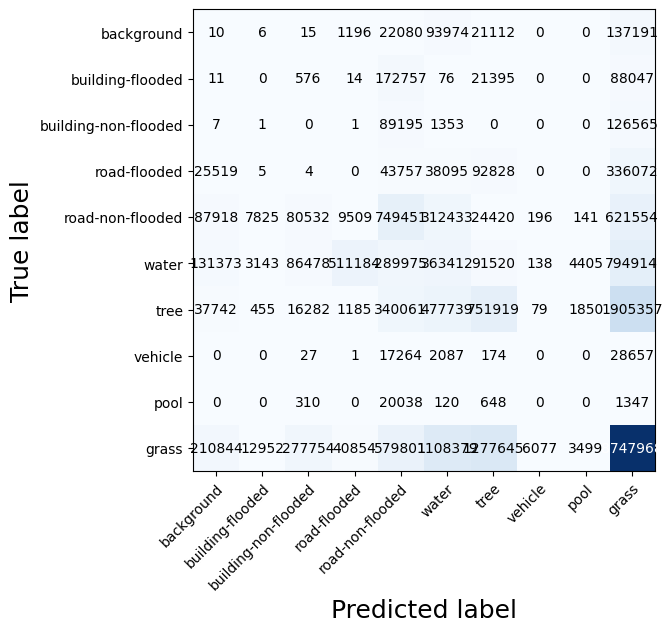

In [28]:
print_confusion_matrix(val_pred_new, val_ground_truth_new, save_name='validation_confusion_matrix')